# Prediction for Diabetes in Adult Females of Pima Indian Heritage


## 1. Introduction:

In the medical industry, the ability to efficiently and effectively detect and remedy diseases is crucial to improving a patient's health. Quite notably, the early detection of diabetes, a chronic metabolic disorder affecting millions worldwide, can prevent serious complications. Luckily, with advancements in data science we can create models to help predict whether a person has diabetes or not by employing the methods of classification. 

Specifically, we hope to answer the following question: Can we employ the plasma glucose concentration and BMI(Body Mass Index) measurements available to us to predict whether an adult female of Pima Indian heritage has diabetes?

Using an existing data set from The National Institute of Diabetes and Digestive and Kidney Diseases, we will create a classification model to determine the answer to our question. All patients listed in this database are females over the age of 21 and of Pima Indian heritage. This data set consists of several medical predictors (independent) variables and one target (dependent) variable, Outcome. They have modeled the outcome on two class variables 0 (does not have diabetes) and 1 (has diabetes).


In [1]:
### run to install necessary libraries ###
library(repr)
library(tidyverse)
library(tidymodels)
options(repr.matrix.max.rows = 6)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.2     ✔ purrr   1.0.1
✔ tibble  3.2.1     ✔ dplyr   1.1.1
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.3     ✔ forcats 0.5.2
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.2     ✔ rsample      1.1.1
✔ dials        1.1.0     ✔ tune         1.0.1
✔ infer        1.0.4     ✔ workflows    1.1.2
✔ modeldata    1.0.1     ✔ workflowsets 1.0.0
✔ parsnip      1.0.3     ✔ yardstick    1.1.0
✔ recipes      1.0.4     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks read

## 2. Preliminary exploratory data analysis:

In [2]:
# read the data
diabetes <- read_csv("https://raw.githubusercontent.com/asnbl/dsci-100-2023-24W-group-16/main/diabetes.csv") 
diabetes

Rows: 768 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (9): Pregnancies, Glucose, BloodPressure, SkinThickness, Insulin, BMI, D...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
6,148,72,35,0,33.6,0.627,50,1
1,85,66,29,0,26.6,0.351,31,0
8,183,64,0,0,23.3,0.672,32,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
5,121,72,23,112,26.2,0.245,30,0
1,126,60,0,0,30.1,0.349,47,1
1,93,70,31,0,30.4,0.315,23,0


In [3]:
# tidy and wrangle data
diabetes_clean <- diabetes |>
    mutate(Outcome = as_factor(Outcome)) |>
    rename("Diabetes" = Outcome) |> 
    mutate(Diabetes = fct_recode(Diabetes, "yes" = "1", "no"  = "0")) |>
    mutate(across(.cols = -Pregnancies, ~replace(., . == 0, NA)))

head(diabetes_clean)

diabetes_split <- initial_split(diabetes_clean, prop = 0.75, strata = Diabetes)
diabetes_train <- training(diabetes_split)
diabetes_test <- testing(diabetes_split) 

Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Diabetes
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
6,148,72,35,NA,33.6,0.627,50,yes
1,85,66,29,NA,26.6,0.351,31,no
8,183,64,NA,NA,23.3,0.672,32,yes
1,89,66,23,94,28.1,0.167,21,no
0,137,40,35,168,43.1,2.288,33,yes
5,116,74,NA,NA,25.6,0.201,30,no


Looking at the original data, there was not a lot that had to be done to tidy the data. However, to make the data easier for the average consumer to interpret, we decided to rename 'Outcome' to 'Diabetes' and refactor its values as "yes" and "no", rather than 1 and 0. After that, we then replaced all 0 values which are not in pregnancies with NA as those 0 values are representative of a lack of a measurement.

### Summarizing the Data

Here, we will summarize properties of our training data, like the proportion of people with diabetes vs no diabetes, means of predictors, and amount of NA values.

In [4]:
# summary
diabetes_proportions <- diabetes_train |>
    group_by(Diabetes) |>
    summarize(count = n()) |>
    mutate(percent = 100*count/nrow(diabetes_train))

diabetes_proportions

Diabetes,count,percent
<fct>,<int>,<dbl>
no,375,65.10417
yes,201,34.89583


From the data frame above, we can see that around 65% of our training data does not have diabetes, and around 35% does.

In [5]:
predictor_means <- diabetes_train |>
    na.omit() |>
    select(-Diabetes) |>
    map_df(mean)

predictor_means

Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
3.33677,121.9588,71.23024,29.46048,157.6564,32.96564,0.5210619,30.82131


In the above data frame, the average value for each predictor is displayed. 

In [6]:
missing_count <- sum(is.na(diabetes_train))

missing_count
dim(diabetes_train)

[1] 488

[1] 576   9

The top number represents how many NA values are in our training data set. Considering that there are 5184 (576 x 9) values, having around 10% be NA should not impact our results too significantly.

### Visualizing the Data

It is important to use summary tables and visualizations to analyze distributions between groups. Here, we will use box plots to look at relationship between the predictor variable and the response variable to do feature selection and narrow down the number of predictor variables we want to use.

Warning message:
“Removed 5 rows containing non-finite values (`stat_boxplot()`).”


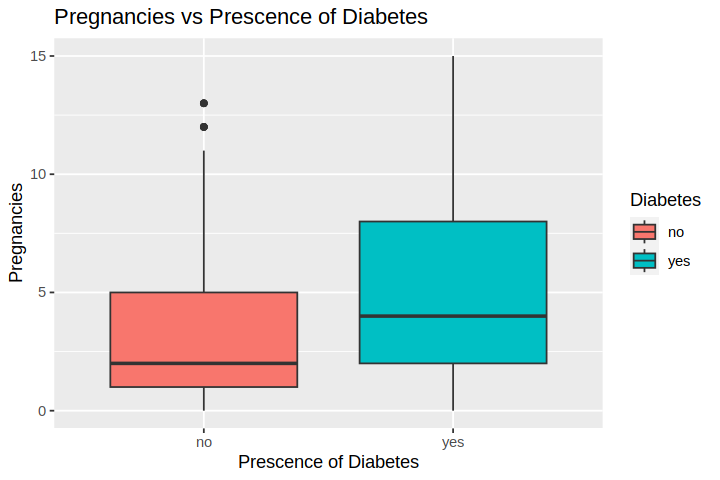

Warning message:
“Removed 25 rows containing non-finite values (`stat_boxplot()`).”


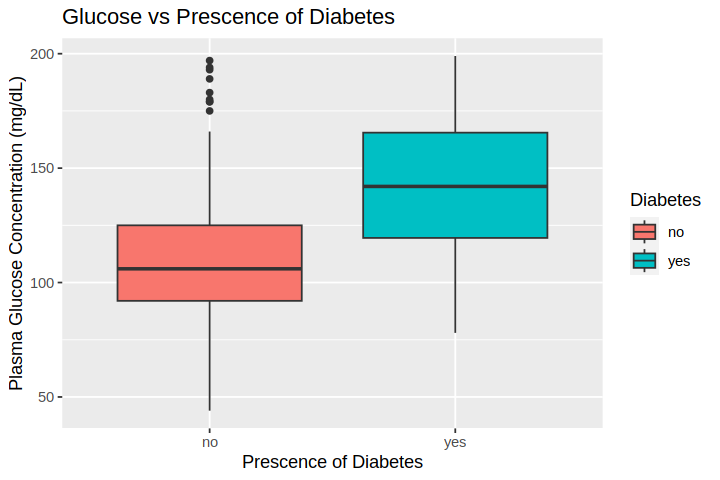

Warning message:
“Removed 166 rows containing non-finite values (`stat_boxplot()`).”


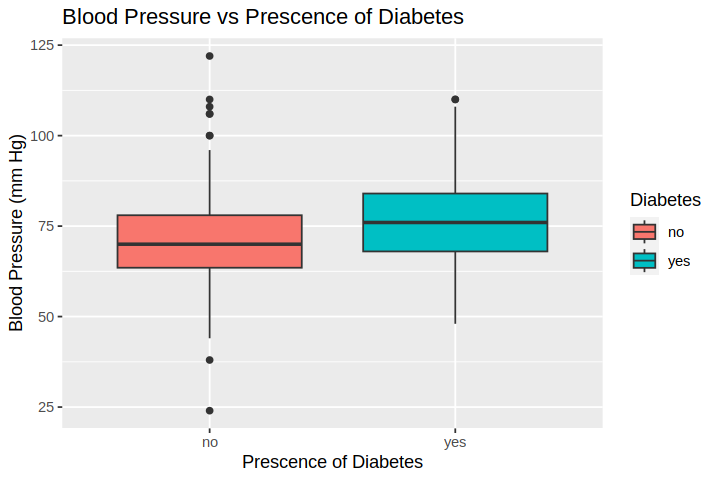

Warning message:
“Removed 283 rows containing non-finite values (`stat_boxplot()`).”


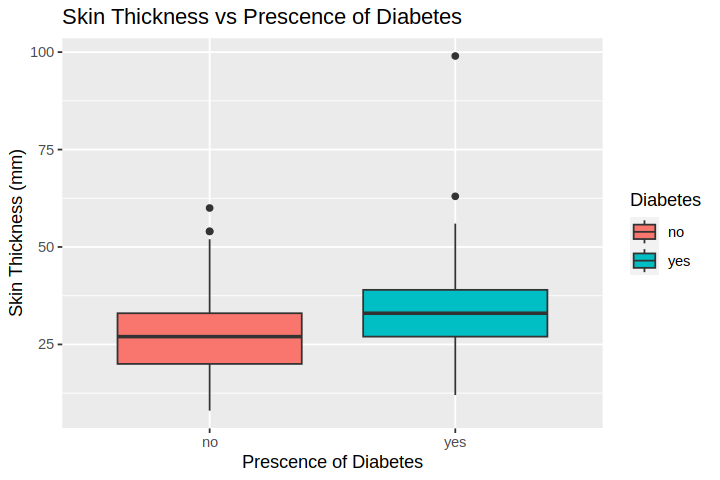

Warning message:
“Removed 9 rows containing non-finite values (`stat_boxplot()`).”


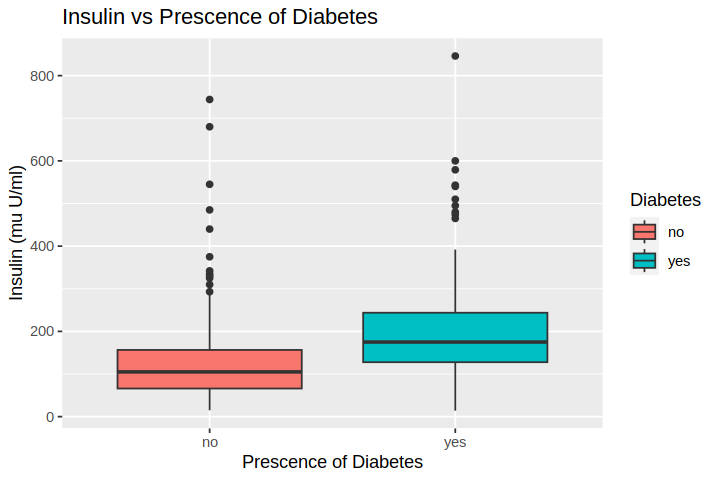

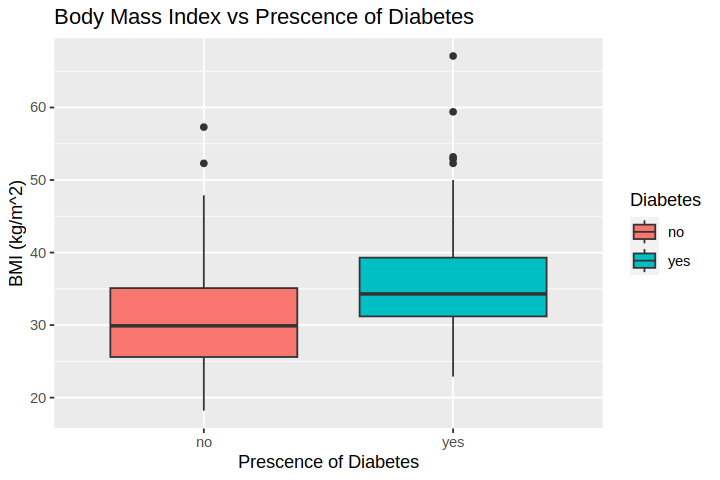

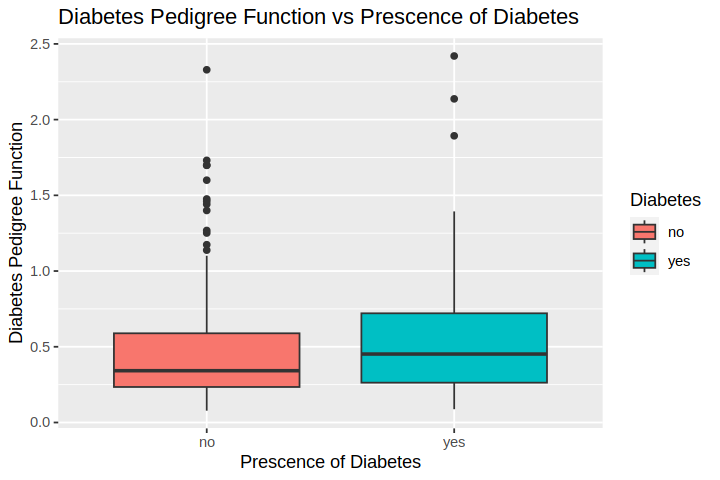

In [7]:
# Set options for plot width and height
options(repr.plot.width = 6, repr.plot.height = 4)

pregnancies <- ggplot(diabetes_train, aes(x = Diabetes, y = Pregnancies, fill = Diabetes)) +
        geom_boxplot() +
        labs( x = "Prescence of Diabetes", y = "Pregnancies") +
        ggtitle("Pregnancies vs Prescence of Diabetes")

glucose <- ggplot(diabetes_train, aes(x = Diabetes, y = Glucose, fill = Diabetes)) +
        geom_boxplot() +
        labs( x = "Prescence of Diabetes", y = "Plasma Glucose Concentration (mg/dL)") +
        ggtitle("Glucose vs Prescence of Diabetes")

blood_pressure <- ggplot(diabetes_train, aes(x = Diabetes, y = BloodPressure, fill = Diabetes)) +
        geom_boxplot() +
        labs( x = "Prescence of Diabetes", y = "Blood Pressure (mm Hg)") +
        ggtitle("Blood Pressure vs Prescence of Diabetes")

skin_thickness <- ggplot(diabetes_train, aes(x = Diabetes, y = SkinThickness, fill = Diabetes)) +
        geom_boxplot() +
        labs( x = "Prescence of Diabetes", y = "Skin Thickness (mm)") +
        ggtitle("Skin Thickness vs Prescence of Diabetes")

insulin <- ggplot(diabetes_train, aes(x = Diabetes, y = Insulin, fill = Diabetes)) +
        geom_boxplot() +
        labs( x = "Prescence of Diabetes", y = "Insulin (mu U/ml)") +
        ggtitle("Insulin vs Prescence of Diabetes")

BMI <- ggplot(diabetes_train, aes(x = Diabetes, y = BMI, fill = Diabetes)) +
        geom_boxplot() + 
        labs( x = "Prescence of Diabetes", y = "BMI (kg/m^2)") +
        ggtitle("Body Mass Index vs Prescence of Diabetes")

diabetes_pedigree_fn <- ggplot(diabetes_train, aes(x = Diabetes, y = DiabetesPedigreeFunction, fill = Diabetes)) +
        geom_boxplot() + 
        labs( x = "Prescence of Diabetes", y = "Diabetes Pedigree Function") +
        ggtitle("Diabetes Pedigree Function vs Prescence of Diabetes")

pregnancies
glucose
blood_pressure
skin_thickness
insulin
BMI
diabetes_pedigree_fn


From the above graphs, it can be seen that the predictors with the least overlap between the boxes for each of the two response variables are glucose and insulin. This means a model using glucose and insulin as predictors will most likely produce the best results.

**Methods:**

1. First, the foundation for building a good classification prediction model is to load the correct libraries and read the data using the read_csv() function.

2. Next, we plan to clean and wrangle the data, as not all 9 of the columns in our data set are useful for our prediction. Using select() function, we will choose our predictors: Glucose and BMI, and also the class we are trying to identify, Diabetes.  

3. We split the data into training and testing sets. Once the model is trained, it can be used to make predictions on new data using the predict() function.

4. Then we would combine pre-processing and model training using a workflow.

5. Then by tuning and using cross-validation, we will determine the optimal k-value to use for our classifier.

6. Finally, we can create a visualization of the cleaned data using a scatter plot.

**Expected outcomes and significance:**

From our model, we expect to find whether or not a woman of Pima Indian ancestry has diabetes. We will do that by taking a point on the plot and with the help of our predictors (glucose levels and BMI) make our prediction. We anticipate discovering whether these specific characteristics are positively or negatively associated with the occurrence of diabetes.

A model like this will not only contribute to the growing field of predictive medicine but also enhance the concept of preventive healthcare practices which can help improve the lives of millions who are susceptible to diabetes and timely intervention and adjustments to their lifestyle can aid in managing the condition and lowering the disease's risk.

After the model identifies individuals at high risk, we can then examine the efficiency of various intervention approaches, such as dietary and exercise programs, to determine which ones are the most effective in preventing diabetes.

**Data Sources:**

https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database
